## import

In [1]:
import json
import numpy as np
import pandas as pd
import folium
from folium import plugins
from folium.features import DivIcon
import matplotlib.pylab as plt
import seaborn as sns

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import warnings ; warnings.filterwarnings('ignore')

### Read Data

In [2]:
GJ_pop = pd.read_csv('../data/ProcessedData/인구정보_gwangjin.csv').set_index('행정동')
GJ_live = pd.read_csv('../data/ProcessedData/주거정보_gwangjin.csv').set_index('행정동')
GJ_economic = pd.read_csv('../data/ProcessedData/경제정보_gwangjin.csv').set_index('행정동')
GJ_food = pd.read_csv('../data/ProcessedData/경제정보_gwangjin_food.csv').set_index('행정동')

GT = pd.read_csv('../data/ProcessedData/gwangjingu_GT.csv').set_index('행정동')
RT = pd.read_csv('../data/ProcessedData/gwangjingu_RT.csv').set_index('행정동')
FT = pd.read_csv('../data/ProcessedData/gwangjingu_FT.csv').set_index('행정동')

In [3]:
result = pd.read_csv('../data/ProcessedData/gwangjingu_score.csv')
result['행정구역'] = result['행정동'].apply(lambda x: f'광진구 {x}')

In [4]:
seoul_dong = json.load(open('../data/HangJeongDong_ver20230101.geojson', encoding='utf-8'))
gwangjin = dict(zip(result['행정구역'], [[] for i in range(15)]))

for i in seoul_dong['features']:
    if i['properties']['sggnm']=="광진구":
        gwangjin[i['properties']['temp']].append(np.mean(i['geometry']['coordinates'][0][0], axis=0))

In [5]:
# 각 값을 조금씩 조정한다.
gwangjin['광진구 군자동'] = [gwangjin['광진구 군자동'][0] + np.array([0,0.002])]
gwangjin['광진구 중곡1동'] = [gwangjin['광진구 중곡1동'][0] + np.array([0,0.002])]
gwangjin['광진구 중곡2동'] = [gwangjin['광진구 중곡2동'][0] + np.array([0.001,0.002])]
gwangjin['광진구 중곡4동'] = [gwangjin['광진구 중곡4동'][0] - np.array([0,0.004])]
gwangjin['광진구 화양동'] = [gwangjin['광진구 화양동'][0] - np.array([0.003,0])]
gwangjin['광진구 자양1동'] = [gwangjin['광진구 자양1동'][0] + np.array([0,0.001])]
gwangjin['광진구 구의1동'] = [gwangjin['광진구 구의1동'][0] + np.array([0.004,0])]
gwangjin['광진구 구의3동'] = [gwangjin['광진구 구의3동'][0] + np.array([0.002,0])]

result = result.merge(pd.DataFrame(gwangjin).T.reset_index().rename(columns={'index':'행정구역',0:'좌표'}), on='행정구역')

## 행정동 별 재활용폐기물위험지수 시각화

In [ ]:
g_map = folium.Map(location = [37.5442, 127.0992], tiles='openstreetmap', zoom_start=13)
g_map.choropleth(geo_data=seoul_dong, data=result, columns=['행정구역', '위험지수_재활용폐기물'], key_on='properties.temp',
                 fill_color='YlGn', fill_opacity=0.8, 
                 line_opacity=0.4, nan_fill_color='darkgray', legend_name='재활용폐기물 위험지수')

for _, dong, score, xy in result[['행정동','위험지수_재활용폐기물','좌표']].itertuples():
    folium.Marker([xy[1], xy[0]-0.003], icon=DivIcon(html=f'<div style="width:50px; height:50px;font-weight: bold;font-size: 5pt">{dong}\n{np.round(score,3)}</div>')).add_to(g_map)
    
g_map

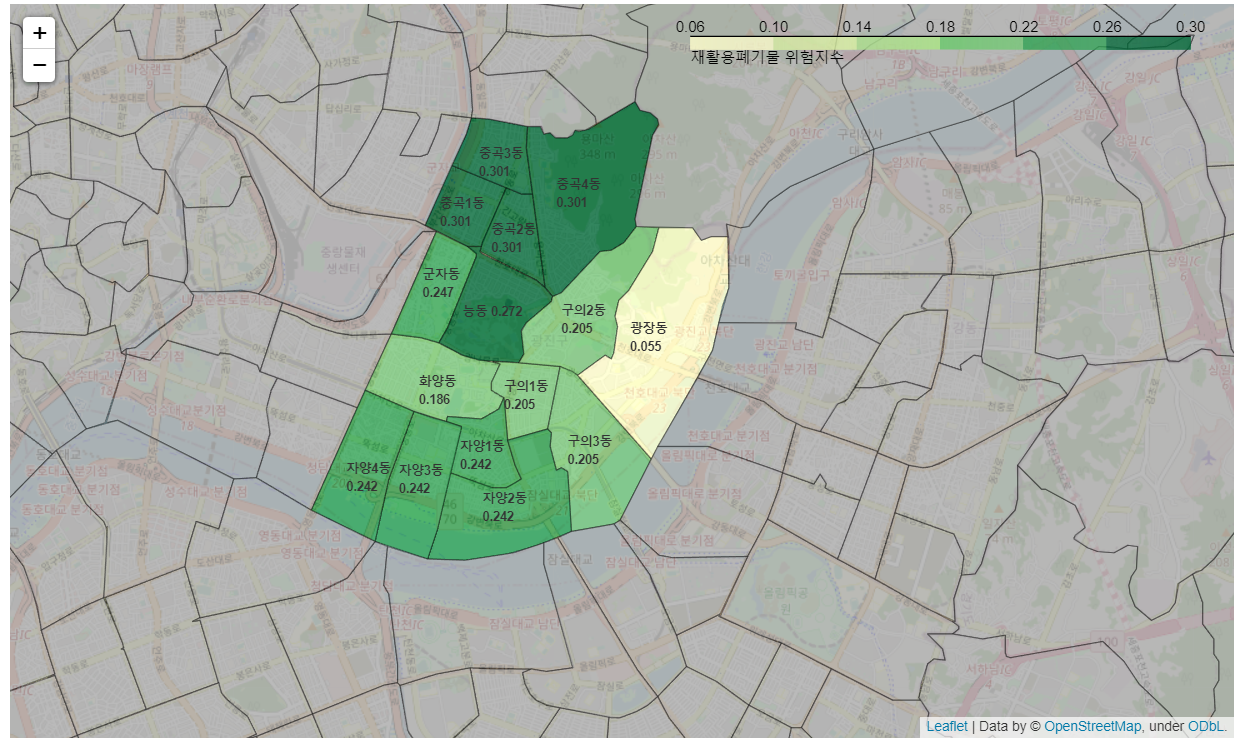

- 중곡동
  - 세대수와 인구수가 많지만 아파트가 적고 빌라와 주택위주이다. 다가구주택 비율이 높아 쓰레기 수거가 효율적이지 못하다.
  - 7호선 중곡역과 인접해 있다.
  - 60대 이상 인구 비율이 높다.
- 능동
  - 다가구주택 거래비율이 압도적으로 높은 능동은 상권지역인 군자동과 인접해 있다는 점까지 작용해 처리 시설이 부족할 것 같다.
- 군자동
  - 대학가로 1인가구가 많이 사는 지역이며 다가구주택이 거래비율이 높다. 또한 상권이 활성화된 곳으로 처리시설을 마련해야 한다.
- 자양동

- 자양4동
  - 2호선 건대입구역에 인접해 있어 교통이 편리하다.
  - 조선족, 중국인이 많다.
- 군자동
  - 세종대학교가 위치하고 있으며 어린이대공원이 있어 주거지가 들어설 면적이 적다.
  - 다가구주택과 다세대주택이 많다.
  - 교통이 편리하며 대학가로 상권이 잘 형성되어 있다.
  - 인구수랑 세대수 자체가 작은 상권 위주의 동네이다.
- 구의3동
  - 60대 이상의 인구 비율이 높다.
  - 광진구 행정동 중 두번째로 인구수가 많다.
  - 5호선 아차산역과 인접해 있다.

재활용쓰레기(중곡2동,중곡3동)
<관련 변수 내용종합>
- 다가구주택의 거래비율이 높고, 밀집해 있는 지역

<동별 수거 방안 아이디어>
- 중곡2동 = 많은 다가구주택들이 좁은 간격으로 밀집해 있어 재활용 쓰레기 수거시 수거 빈도가 너무 잦아 효율적인 수거가 되지 않을 것이라 판단됨
[수거거점지역 시스템 구축]
 다가구주택들의 밀집구역을 묶어 각 구역별로 중심거점에 구역 대표 재활용 수거함을 설치한다
 이렇게 하면 각 주택별로 수거함들을 돌며 시간적으로나 비용적으로 비효율적인 수거를 피할 수 있을 것으로 판단된다

- 중곡3동 = 많은 다가구주택들이 분포해 있고 대로변에 여러 상가들이 밀집해 있다 
[재활용 마일리지 카드 제공]
 다가구주택 즉, 1인가구들은 잦은 빈도로 생필품이나 식료품을 구입하는 경향이 있으므로 재활용 쓰레기 수거함에 카드를 인식할 수 있는 태그를 부착해
 알맞게 분리수거를 했을 시 마일리지를 쌓을 수 있는 시스템을 구축한다
 중곡3동 지역특성상 다가구주택 뿐만 아니라 주변에 마일리지를 사용할 수 있는 상가점포들이 많이 분포해 있으므로
 거주민들에게 재활용 마일리지 카드를 제공하여 인센티브를 제공한다면 재활용 쓰레기를 수거하여 추가적으로 재분리해야하는 번거로움도 
 덜 수 있고  추가적으로 주변 상권을 활성화 할 수 있다고 판단된다. 


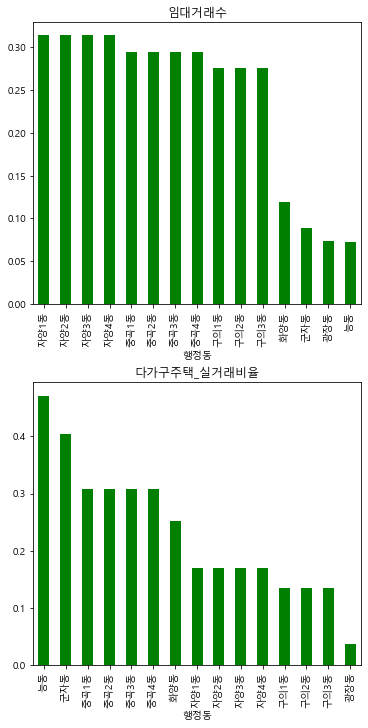

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(5, 10), constrained_layout=True)
RT.iloc[:,0].sort_values(ascending=False).plot.bar(title=RT.columns[0], ax=ax[0],color='green')
RT.iloc[:,1].sort_values(ascending=False).plot.bar(title=RT.columns[1], ax=ax[1],color='green')
plt.show()